In [ ]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best Architecture: layer1_neurons=99, layer2_neurons=95


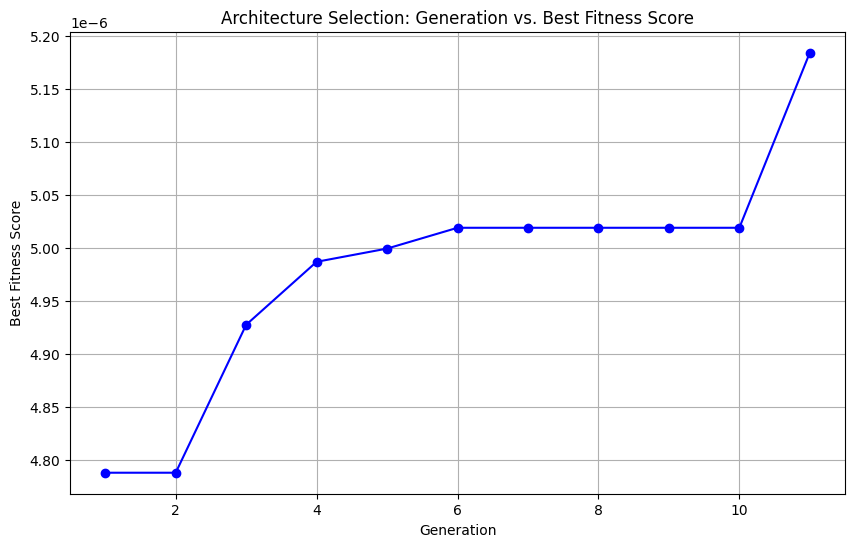

Final Model RMSE: 201215.875
Final Model R^2 Score: -2.214972257241527


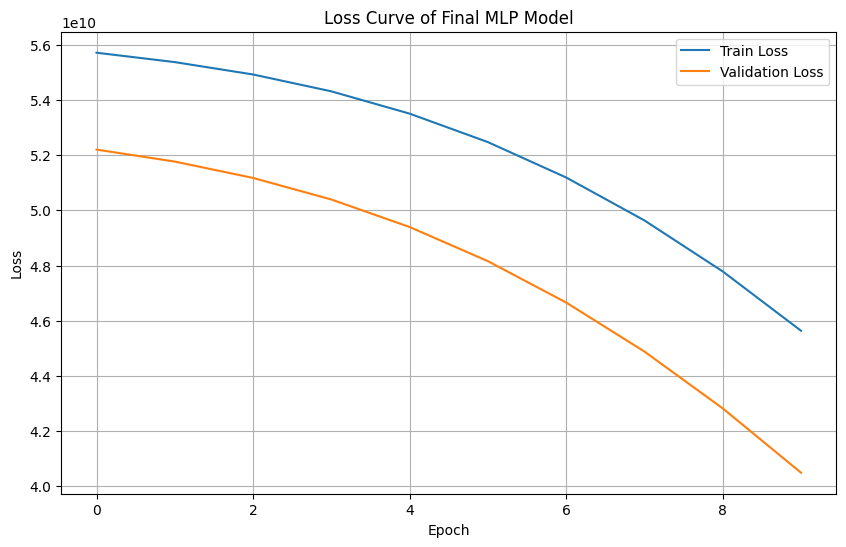

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pygad
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/sample_data/california_housing_test.csv')

# Separate features and target
X = data.drop(columns=['median_house_value']).values
y = data['median_house_value'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Step 1: Define MLP architectures using GA
# Define the fitness function for architecture selection
def architecture_fitness_func(ga_instance, solution, solution_idx):
    # Extract the number of neurons for two hidden layers from the solution
    layer1_neurons = int(solution[0])
    layer2_neurons = int(solution[1])

    # Create the MLP model
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], layer1_neurons),
        nn.ReLU(),
        nn.Linear(layer1_neurons, layer2_neurons),
        nn.ReLU(),
        nn.Linear(layer2_neurons, 1)
    )

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model (max epochs = 10)
    model.train()
    for epoch in range(10):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()

    # The lower the RMSE, the higher the fitness score
    return 1.0 / (rmse + 1e-6)

# Set the parameters for the GA for architecture selection
architecture_ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=5,
    fitness_func=architecture_fitness_func,
    sol_per_pop=10,
    num_genes=2,  # Number of neurons in 2 hidden layers
    gene_space=[{'low': 5, 'high': 100}, {'low': 5, 'high': 100}],
    parent_selection_type="sss",
    crossover_type="single_point",
    mutation_type="random",
    keep_parents=2
)

# Run the GA to optimize MLP architecture
architecture_ga_instance.run()

# Extract the best solution for architecture selection
architecture_solution, architecture_solution_fitness, architecture_solution_idx = architecture_ga_instance.best_solution()
layer1_neurons = int(architecture_solution[0])
layer2_neurons = int(architecture_solution[1])

print(f"Best Architecture: layer1_neurons={layer1_neurons}, layer2_neurons={layer2_neurons}")

# Plot generation vs best fitness score for architecture selection
generations = list(range(1, len(architecture_ga_instance.best_solutions_fitness) + 1))
best_solutions_fitness = architecture_ga_instance.best_solutions_fitness

plt.figure(figsize=(10, 6))
plt.plot(generations, best_solutions_fitness, marker='o', linestyle='-', color='b')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Architecture Selection: Generation vs. Best Fitness Score')
plt.grid()
plt.show()

# Step 2: Train the final MLP model with the best architecture
final_model = nn.Sequential(
    nn.Linear(X_train.shape[1], layer1_neurons),
    nn.ReLU(),
    nn.Linear(layer1_neurons, layer2_neurons),
    nn.ReLU(),
    nn.Linear(layer2_neurons, 1)
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.01)

# Train the final model (max epochs = 10)
train_losses = []
val_losses = []
final_model.train()
for epoch in range(10):
    # Training step
    optimizer.zero_grad()
    outputs = final_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation step
    with torch.no_grad():
        final_model.eval()
        val_predictions = final_model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor).item()
        val_losses.append(val_loss)
    final_model.train()

# Evaluate the model
final_model.eval()
with torch.no_grad():
    predictions = final_model(X_test_tensor)
    rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()
    r2 = r2_score(y_test, predictions.numpy())

print(f"Final Model RMSE: {rmse}")
print(f"Final Model R^2 Score: {r2}")

# Plot the loss curve of the final model
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve of Final MLP Model')
plt.legend()
plt.grid()
plt.show()


In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=1dbbec7451b27bb957dc2adc19f03f3db5d5ff259c2d4ddf978c4b42235d8312
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

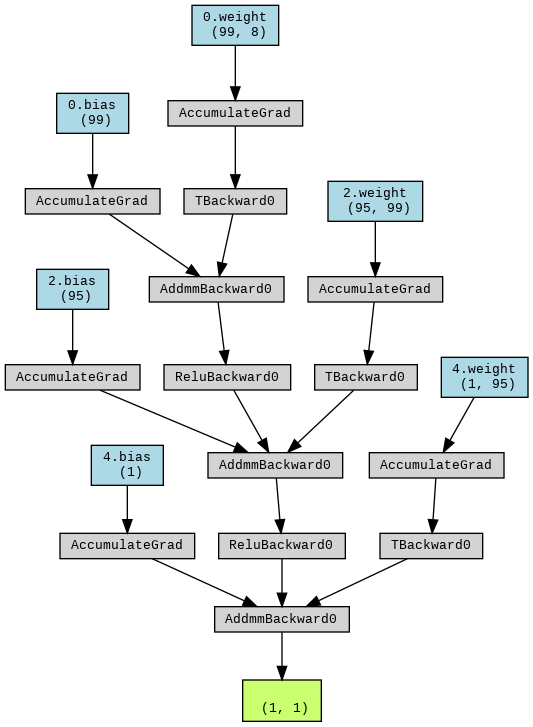

In [ ]:
# Visualize the final neural network architecture
x = torch.randn(1, X_train.shape[1], dtype=torch.float32)
y = final_model(x)
dot = make_dot(y, params=dict(final_model.named_parameters()))
dot.format = 'png'
dot.render('mlp_architecture')

# Display the architecture
from IPython.display import Image
Image(filename='mlp_architecture.png')

In [ ]:
!pip install neat-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.3 MB/s eta 0:00:00



 ****** Running generation 0 ****** 

Population's average fitness: -236223.21405 stdev: 0.00000
Best fitness: -236223.21405 - size: (1, 0) - species 1 - id 1
Average adjusted fitness: -0.000
Mean genetic distance 0.932, standard deviation 0.682
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150  -236223.2   -0.000     0
Total extinctions: 0
Generation time: 0.802 sec

 ****** Running generation 1 ****** 

Population's average fitness: -236223.18782 stdev: 0.44680
Best fitness: -236222.33652 - size: (1, 1) - species 1 - id 158
Average adjusted fitness: 0.515
Mean genetic distance 1.485, standard deviation 0.523
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150  -236222.3    0.515     0
Total extinctions: 0
Generation time: 0.909 sec (0.855 average)

 ****** Running generation 2 ****** 

Population's avera

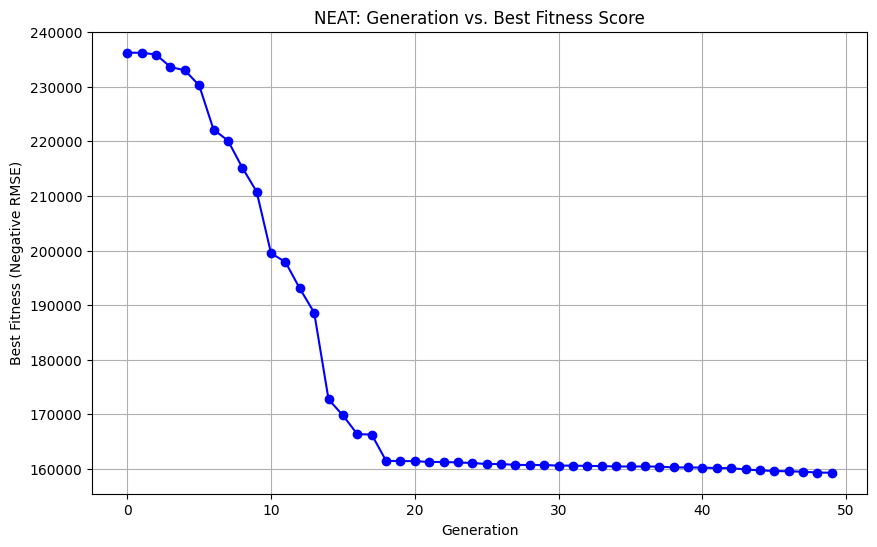

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import neat
import matplotlib.pyplot as plt
from torchviz import make_dot

# Load the dataset
data = pd.read_csv('/content/sample_data/california_housing_test.csv')

# Separate features and target
X = data.drop(columns=['median_house_value']).values
y = data['median_house_value'].values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the NEAT configuration
config_path = "/content/sample_data/neat-config.txt"  # Assuming you have a NEAT config file named neat-config.txt
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

# Define the fitness function for NEAT
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        # Convert genome to a PyTorch neural network
        net = neat.nn.FeedForwardNetwork.create(genome, config)

        # Convert the training data to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

        # Predict on the training data
        predictions = []
        for x in X_train:
            output = net.activate(x)
            predictions.append(output[0])

        # Calculate RMSE as fitness
        rmse = np.sqrt(mean_squared_error(y_train, predictions))
        genome.fitness = -rmse  # NEAT minimizes the error, so we return negative RMSE

# Create the population
p = neat.Population(config)

# Add reporters to show progress
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

# Run NEAT to evolve the neural network
winner = p.run(eval_genomes, 50)

# Convert the winning genome to a PyTorch model
best_net = neat.nn.FeedForwardNetwork.create(winner, config)

# Evaluate the best network on the test set
y_pred = []
for x in X_test:
    output = best_net.activate(x)
    y_pred.append(output[0])

# Calculate final metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Final Model RMSE: {rmse}")
print(f"Final Model R^2 Score: {r2}")

# Plot the loss curve for NEAT (since NEAT does not have a built-in loss curve, we will track and plot the best fitness score)
best_fitness_scores = [-c.fitness for c in stats.most_fit_genomes]
plt.figure(figsize=(10, 6))
plt.plot(best_fitness_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Negative RMSE)')
plt.title('NEAT: Generation vs. Best Fitness Score')
plt.grid()
plt.show()

# Note: Visualizing the neural network architecture is more complex with NEAT, as it evolves dynamic topologies.
# You could use a library like graphviz to create a graph from the NEAT network if needed.


In [ ]:
!pip install graphviz

In [ ]:
import graphviz

def visualize_neat_network(genome, config, filename="neat_network"):
    # Create a Digraph for visualization
    dot = graphviz.Digraph(format='png', engine='dot')

    # Create nodes for inputs, outputs, and hidden layers
    input_names = [f"Input {i}" for i in range(config.genome_config.num_inputs)]
    output_names = [f"Output {i}" for i in range(config.genome_config.num_outputs)]

    # Input nodes
    for i in range(config.genome_config.num_inputs):
        dot.node(f"input_{i}", input_names[i], shape='circle', color='lightblue')

    # Output nodes
    for i in range(config.genome_config.num_outputs):
        dot.node(f"output_{i}", output_names[i], shape='circle', color='lightgreen')

    # Hidden nodes
    for node_id in genome.nodes:
        if node_id not in range(config.genome_config.num_inputs) and node_id not in range(-1, -config.genome_config.num_outputs - 1, -1):
            dot.node(f"node_{node_id}", f"Hidden {node_id}", shape='circle', color='orange')

    # Add connections between nodes
    for connection_key, connection in genome.connections.items():
        if connection.enabled:
            from_node, to_node = connection_key
            dot.edge(f"node_{from_node}", f"node_{to_node}", label=f"{connection.weight:.2f}")

    # Render the graph to file
    dot.render(filename, view=True)

# Visualize the winner network using Graphviz
visualize_neat_network(winner, config)
